<a href="https://colab.research.google.com/github/seenu-g/eva4-2/blob/master/week2/experiment/EVA4_S2_mobilnet_v2_transfer_learning_v4b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [2]:
 pip install torch-lr-finder 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images.zip
!unzip -q final_images.zip
!rm -rf /content/__MACOSX
!find /content/final_images/data -name '.DS_Store' -type f -delete

In [8]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [9]:
from Modules import *

In [10]:
split_test_train_data('/content/final_images/data', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6761
4165
3653
5673


In [11]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= 192, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= 192,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

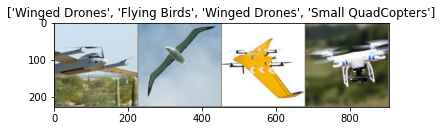

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


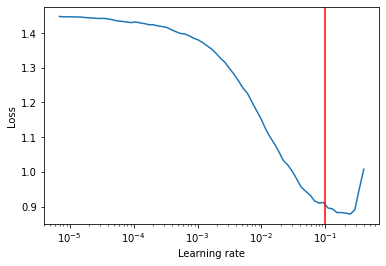

In [13]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [15]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.8642 Acc: 0.6778
val Loss: 1.1325 Acc: 0.7754

Epoch 1/24
----------
train Loss: 1.3024 Acc: 0.7316
val Loss: 0.8394 Acc: 0.7940

Epoch 2/24
----------
train Loss: 1.2774 Acc: 0.7235
val Loss: 1.0161 Acc: 0.7746

Epoch 3/24
----------
train Loss: 1.4170 Acc: 0.7264
val Loss: 0.8499 Acc: 0.8087

Epoch 4/24
----------
train Loss: 1.2503 Acc: 0.7253
val Loss: 0.8849 Acc: 0.8022

Epoch 5/24
----------
train Loss: 1.4151 Acc: 0.7200
val Loss: 1.5433 Acc: 0.7234

Epoch 6/24
----------
train Loss: 1.2455 Acc: 0.7255
val Loss: 1.0719 Acc: 0.7667

Epoch 7/24
----------
train Loss: 1.4339 Acc: 0.7236
val Loss: 1.3925 Acc: 0.7359

Epoch 8/24
----------
train Loss: 1.2774 Acc: 0.7312
val Loss: 1.1486 Acc: 0.7683

Epoch 9/24
----------
train Loss: 1.1911 Acc: 0.7307
val Loss: 0.8717 Acc: 0.7902

Epoch 10/24
----------
train Loss: 1.4559 Acc: 0.7166
val Loss: 1.0722 Acc: 0.8179

Epoch 11/24
----------
train Loss: 1.2696 Acc: 0.7309
val Loss: 0.7669 Acc: 0.7902

Epoch 12/24
----------
t

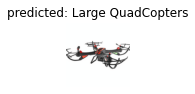

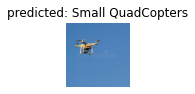

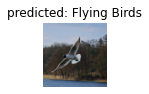

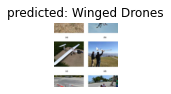

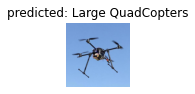

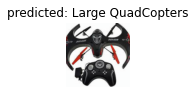

In [16]:
visualize_model(model_res, dataloaders, class_names, device)

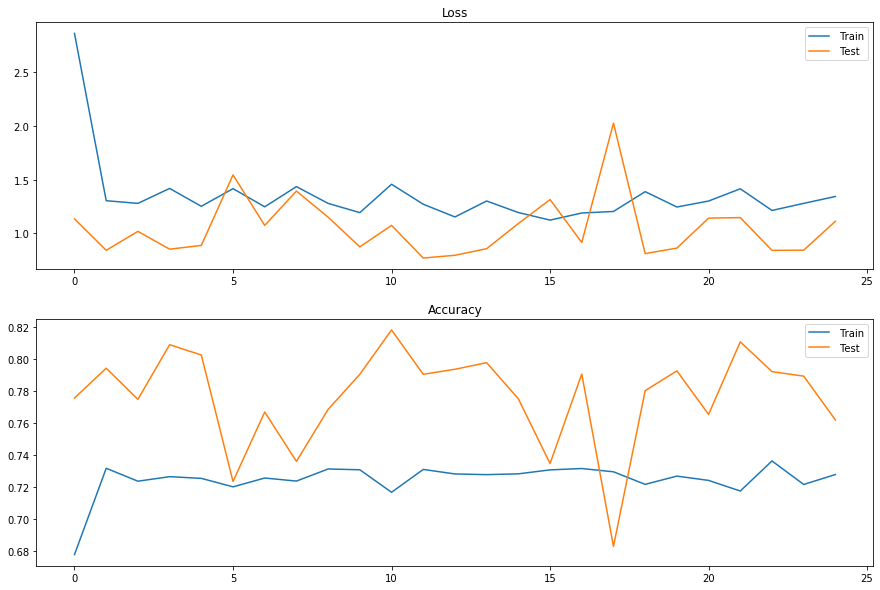

In [17]:
PlotGraph(plotData)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


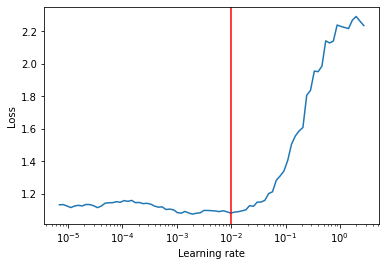

In [18]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [19]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25)

In [20]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9095 Acc: 0.7565
val Loss: 0.5064 Acc: 0.8240

Epoch 1/24
----------
train Loss: 0.5989 Acc: 0.7785
val Loss: 0.4328 Acc: 0.8360

Epoch 2/24
----------
train Loss: 0.5113 Acc: 0.8013
val Loss: 0.3760 Acc: 0.8569

Epoch 3/24
----------
train Loss: 0.4406 Acc: 0.8233
val Loss: 0.3691 Acc: 0.8620

Epoch 4/24
----------
train Loss: 0.4181 Acc: 0.8310
val Loss: 0.3644 Acc: 0.8515

Epoch 5/24
----------
train Loss: 0.3902 Acc: 0.8447
val Loss: 0.3232 Acc: 0.8844

Epoch 6/24
----------
train Loss: 0.3733 Acc: 0.8541
val Loss: 0.3366 Acc: 0.8749

Epoch 7/24
----------
train Loss: 0.3585 Acc: 0.8580
val Loss: 0.3240 Acc: 0.8874

Epoch 8/24
----------
train Loss: 0.3421 Acc: 0.8653
val Loss: 0.3192 Acc: 0.8907

Epoch 9/24
----------
train Loss: 0.3201 Acc: 0.8778
val Loss: 0.3256 Acc: 0.8893

Epoch 10/24
----------
train Loss: 0.3124 Acc: 0.8757
val Loss: 0.3055 Acc: 0.8928

Epoch 11/24
----------
train Loss: 0.3021 Acc: 0.8852
val Loss: 0.3281 Acc: 0.8836

Ep

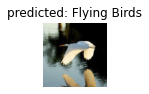

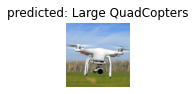

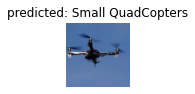

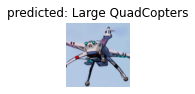

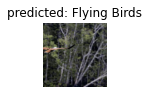

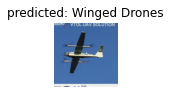

In [21]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()

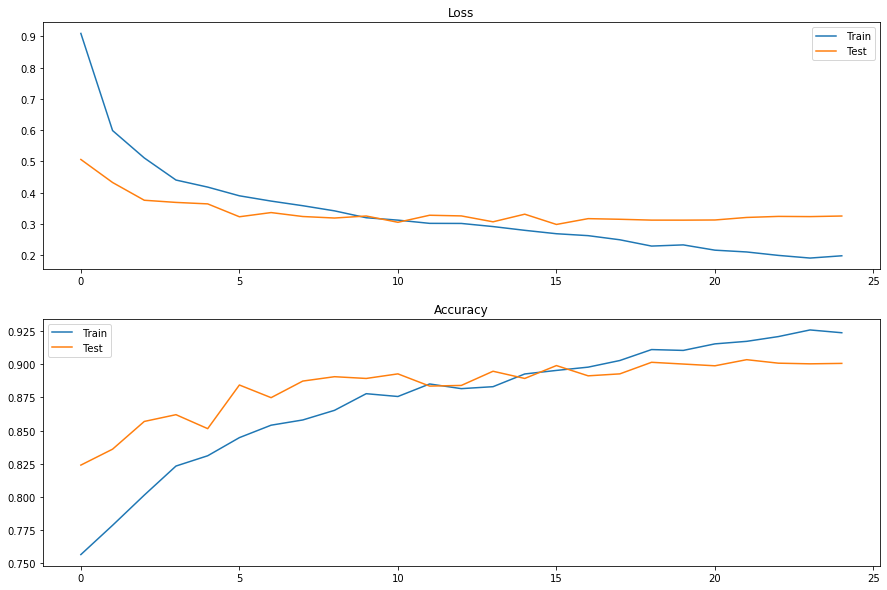

In [22]:
PlotGraph(plotData)

# 9. Saving Model

In [23]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v4b.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v4b.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v4b.pt')